# Smart Housing Advisor
Tri Blankley and Kassidy Maberry

2025/05/06

Data provided by Redfin, a national real estate brokerage.

Link: https://www.redfin.com/news/data-center

In [1]:
import pandas as pd
import matplotlib.pyplot as mlp
import seaborn as sb
import plotly.express as px

"""
Loads plot data.
"""
def load_data():
    d = pd.read_csv("city_market_tracker.tsv000", sep="\t")
    d["PERIOD_BEGIN"] = pd.to_datetime(d["PERIOD_BEGIN"])
    d["PERIOD_END"] = pd.to_datetime(d["PERIOD_END"])
    # TODO: Convert dates into datatime.
    return d

data = load_data()
print("Data has loaded")

Data has loaded


In [9]:
print(data.keys())

Index(['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE',
       'REGION_TYPE_ID', 'TABLE_ID', 'IS_SEASONALLY_ADJUSTED', 'REGION',
       'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'PROPERTY_TYPE_ID',
       'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY',
       'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY',
       'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF',
       'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD',
       'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES',
       'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS',
       'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM',
       'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM',
       'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM',
       'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM',
       'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM',
 

# Task 1: User Input

In [3]:
income = float(input("Enter your annual income: "))
downPay = float(input("Enter your down payment: "))
prefered = input("Enter your prefered city (optional): ")

Enter your annual income:  32000
Enter your down payment:  2000
Enter your prefered city (optional):  s


# Task 2: Affordability Estimation

In [15]:
monthlyBudget = (income * .3)/12
loanDur = int(input("Enter a loan duration in months: "))
houseBudget = downPay + monthlyBudget * loanDur
out = data[data["MEDIAN_SALE_PRICE"] <= houseBudget]
out = out[["MEDIAN_SALE_PRICE", "CITY"]]
print("You can afford houses from the following cities.")
print(out)

Enter a loan duration in months:  10


You can afford houses from the following cities.
         MEDIAN_SALE_PRICE          CITY
858                 1450.0      Bancroft
927                 1675.0  Prairieville
1836                2500.0  Center Point
2102               10000.0         Flint
2123                3600.0     Ehrenfeld
...                    ...           ...
5816952              495.0  Lincoln Park
5817433             9750.0         Benld
5817762             7000.0         Ocala
5817867             8800.0    Leachville
5818481             9387.5    Lindenwold

[13115 rows x 2 columns]


# Task 3: Market Trend Analysis

Enter your prefered city (optional):  Chicago


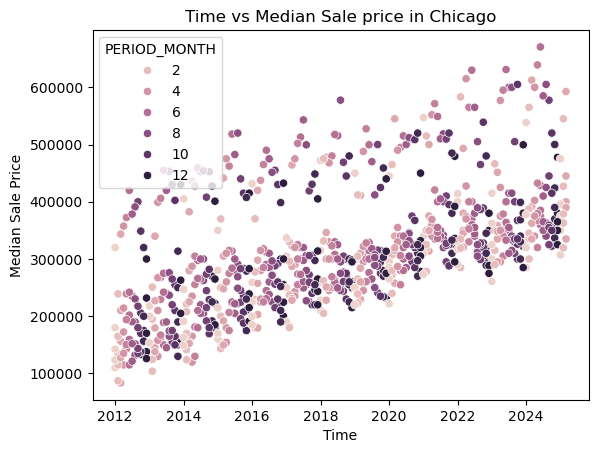

In [3]:
city = input("Enter your prefered city (optional): ")
market = data[data["CITY"] == city]
if market.size == 0:
    print("Unknown city defaulting to all")
    market = data
    city = ""
else:
    city = " in " + city

market.insert(1, "PERIOD_YEAR", market["PERIOD_BEGIN"].dt.year)
market.insert(1, "PERIOD_MONTH", market["PERIOD_BEGIN"].dt.month)
sb.scatterplot(market, x="PERIOD_BEGIN", y="MEDIAN_SALE_PRICE", hue="PERIOD_MONTH")
mlp.xlabel("Time")
mlp.ylabel("Median Sale Price")
mlp.title(f"Time vs Median Sale price{city}")
mlp.show()

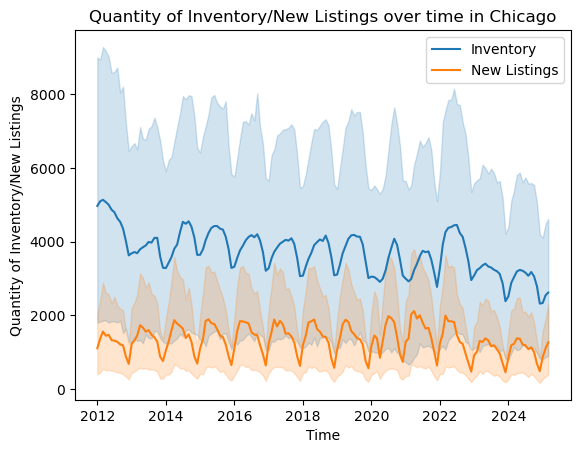

In [4]:
sb.lineplot(market, x="PERIOD_BEGIN", y="INVENTORY", label="Inventory")
sb.lineplot(market, x="PERIOD_BEGIN", y="NEW_LISTINGS", label="New Listings")
mlp.ylabel("Quantity of Inventory/New Listings")
mlp.xlabel("Time")
mlp.title(f"Quantity of Inventory/New Listings over time{city}")
mlp.show()

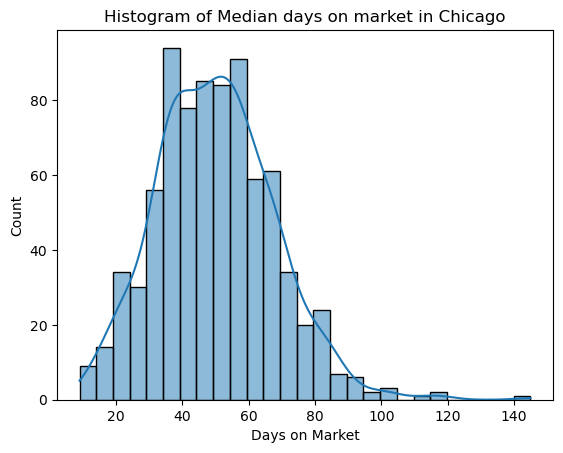

In [12]:
sb.histplot(market, x="MEDIAN_DOM", kde=True)
mlp.title(f"Histogram of Median days on market{city}")
mlp.xlabel("Days on Market")
mlp.show()

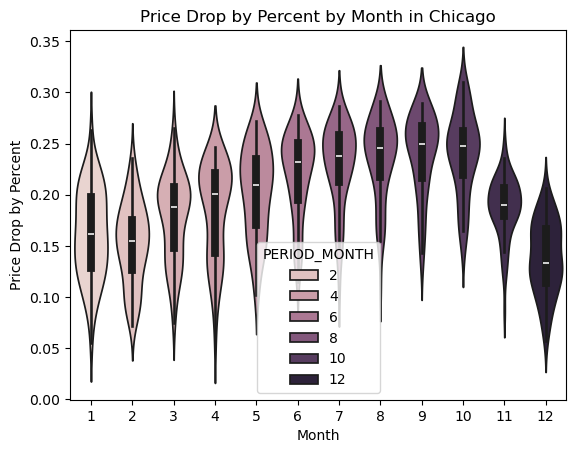

In [11]:
sb.violinplot(market, x="PERIOD_MONTH", y="PRICE_DROPS", hue="PERIOD_MONTH")
mlp.title(f"Price Drop by Percent by Month{city}")
mlp.xlabel("Month")
mlp.ylabel("Price Drop by Percent")
mlp.show()

In [20]:
houses = data[data["MEDIAN_SALE_PRICE"] <= houseBudget]
fig = px.scatter(houses, x="MEDIAN_SALE_PRICE", y="CITY")
fig.show()
# I don't know why its not working but that should be a valid plot.

# Task 4: Generate Insights

In [15]:
print(f"Your estimated house budget is ${houseBudget}")

out = data[data["MEDIAN_SALE_PRICE"] <= houseBudget]
out = out[["CITY", "STATE_CODE"]]
vals = out.values
val = int(input("How many cities do you want to print?"))
i = 0
print("Places that fit your budget:")
for c in vals:
    if i == val:
        break
    print(f"- {c[0]}, {c[1]}")
    i += 1

if i == 0:
    print("We searched far and wide but no cities fit your budget.")

# Where to buy and not buy.
# So what we could do is get the min and max for each city of the period start. Then compare the
# Median price change between the two. We'd need to group by and then aggregate.

Your estimated house budget is $50000.0


How many cities do you want to print? 5


Places that fit your budget:
- Hartshorne, OK
- Cedar Glen West, NJ
- Hagerstown, IN
- Fairmont City, IL
- Bellaire, OH
